In [ ]:
!pip install gensim
!pip install tensorflow
import nltk
nltk.download('punkt_tab')

In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
train = pd.read_csv('../../data/yelp/train_en.txt', sep='\t')
test = pd.read_csv('../../data/yelp/test_en.txt', sep='\t')
val = pd.read_csv('../../data/yelp/val_en.txt', sep='\t')
train['Tokens'] = train['Sentence'].apply(lambda x: word_tokenize(x.lower()))
test['Tokens'] = test['Sentence'].apply(lambda x: word_tokenize(x.lower()))
val['Tokens'] = val['Sentence'].apply(lambda x: word_tokenize(x.lower()))

#### Word2Vec Model Training

In [4]:
sentences = train['Tokens'].values

In [5]:
model_word2vec = Word2Vec(sentences, vector_size=50, min_count=15, sg=1)

In [6]:
print(len(model_word2vec.wv.index_to_key))
print(len(model_word2vec.wv.key_to_index.keys()))

27414
27414


In [7]:
words = model_word2vec.wv.index_to_key
word_vectors = model_word2vec.wv.vectors

#### Vocabulary Preparation with UNK Token

In [8]:
unk_vector = np.random.randn(50)
word_vectors = np.vstack([word_vectors, unk_vector])
words.append('<UNK>')

In [9]:
print(len(words))
print(len(word_vectors))

27415
27415


In [10]:
words_to_idx = {token: idx for idx, token in enumerate(words)}
unk_idx = words_to_idx['<UNK>']
unk_idx

27414

#### Token to Index Conversion

In [11]:
def convert_tokens_to_indices(tokens, vocab_dict, unknown_idx):
    return [vocab_dict.get(token, unknown_idx) for token in tokens]

In [12]:
train['ID'] = train['Tokens'].apply(
    lambda tokens: [words_to_idx[token] if token in words_to_idx.keys()
                    else words_to_idx['<UNK>'] for token in tokens]
)

In [13]:
val['ID'] = val['Tokens'].apply(
    lambda tokens: [words_to_idx[token] if token in words_to_idx.keys()
                    else words_to_idx['<UNK>'] for token in tokens]
)

In [14]:
test['ID'] = test['Tokens'].apply(
    lambda tokens: [words_to_idx[token] if token in words_to_idx.keys()
                    else words_to_idx['<UNK>'] for token in tokens]
)

In [15]:
train_ids = train['ID'].values
val_ids = val['ID'].values
test_ids = test['ID'].values

#### Sequence Padding

In [16]:
avg_seq_len = np.mean(train['ID'].apply(lambda x: len(x)).values)
sequence_length = int(avg_seq_len)

In [17]:
print(f"Average tokens per sentence: {avg_seq_len:.2f}")
print(f"Using sequence length: {sequence_length}")

Average tokens per sentence: 131.13
Using sequence length: 131


In [18]:
train_pad_ids = pad_sequences(train_ids, maxlen=sequence_length)
val_pad_ids = pad_sequences(val_ids, maxlen=sequence_length)
test_pad_ids = pad_sequences(test_ids, maxlen=sequence_length)

#### Label Encoding

In [19]:
labels_train = train['Style'].values
print(labels_train)

['positive' 'negative' 'negative' ... 'negative' 'positive' 'positive']


In [20]:
labels_val = val['Style'].values
print(labels_val)

['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']


In [21]:
labels_test = test['Style'].values
print(labels_test)

['positive' 'negative' 'positive' ... 'positive' 'positive' 'positive']


In [22]:
LE = LabelEncoder()
LE.fit(labels_train)

LabelEncoder()

In [23]:
y_train = LE.transform(labels_train)
y_val =  LE.transform(labels_val)
y_test = LE.transform(labels_test)
y_train

array([1, 0, 0, ..., 0, 1, 1], shape=(342905,))

#### LSTM Model

In [24]:
model = Sequential()

In [25]:
model.add(Embedding(input_dim=len(words), output_dim=50,
                    weights=[word_vectors], trainable=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(train_pad_ids, y_train,
    validation_data=(val_pad_ids, y_val), epochs=5, batch_size=128, verbose=1 )

Epoch 1/5
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 267s 99ms/step - accuracy: 0.8477 - loss: 0.3532 - val_accuracy: 0.8861 - val_loss: 0.2750
Epoch 2/5
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 274s 102ms/step - accuracy: 0.8934 - loss: 0.2617 - val_accuracy: 0.8973 - val_loss: 0.2562
Epoch 3/5
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 299s 111ms/step - accuracy: 0.9056 - loss: 0.2344 - val_accuracy: 0.9019 - val_loss: 0.2444
Epoch 4/5
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 290s 108ms/step - accuracy: 0.9135 - loss: 0.2160 - val_accuracy: 0.9033 - val_loss: 0.2432
Epoch 5/5
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 297s 111ms/step - accuracy: 0.9206 - loss: 0.1996 - val_accuracy: 0.9016 - val_loss: 0.2487


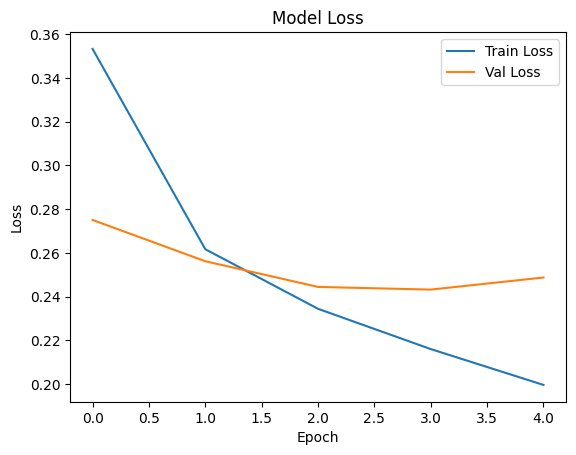

In [27]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
pred = model.predict(test_pad_ids)
pred_binary = (pred > 0.5).astype(int)

1340/1340 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step


In [29]:
print(f'Accuracy: {accuracy_score(y_test, pred_binary)}')
print(f'Precision: {precision_score(y_test, pred_binary)}')
print(f'Recall: {recall_score(y_test, pred_binary)}')
print(f'F1-score: {f1_score(y_test, pred_binary)}')

Accuracy: 0.9014790966778649
Precision: 0.9256713554987213
Recall: 0.9384824814442679
F1-score: 0.9320328971721952


In [30]:
first_result = {
    'config': {'lr': 0.001, 'epochs': 5, 'lstm_units': 128, 'dropout': 0.2, 'recurrent_dropout': 0.2, 'name': 'original_5epochs'},
    'accuracy': accuracy_score(y_test, pred_binary),
    'precision': precision_score(y_test, pred_binary),
    'recall': recall_score(y_test, pred_binary),
    'f1': f1_score(y_test, pred_binary),
    'history': history
}

#### Hyperparameter Tuning and Comparison

In [31]:
configs = [
    {'lr': 0.001, 'epochs': 3, 'lstm_units': 128, 'layers': 1, 'name': 'baseline'},
    {'lr': 0.01, 'epochs': 3, 'lstm_units': 128, 'layers': 1, 'name': 'high_lr'},
    {'lr': 0.001, 'epochs': 3, 'lstm_units': 64, 'layers': 1, 'name': 'small_lstm'},
    {'lr': 0.001, 'epochs': 3, 'lstm_units': 128, 'layers': 2, 'name': 'two_layers'},
]

In [32]:
results = [first_result]
for config in configs:
    model = Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=50,
                        weights=[word_vectors], trainable=True))

    if config['layers'] == 1:
        model.add(LSTM(config['lstm_units'], dropout=0.2,
                       recurrent_dropout=0.2))
    else:
        model.add(LSTM(config['lstm_units'], dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        model.add(LSTM(config['lstm_units'], dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(Adam(learning_rate=config['lr']),
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_pad_ids, y_train,
                       validation_data=(val_pad_ids, y_val),
                       epochs=config['epochs'], batch_size=128, verbose=1)

    pred = model.predict(test_pad_ids)
    pred_binary = (pred > 0.5).astype(int).flatten()

    results.append({
        'config': config,
        'accuracy': accuracy_score(y_test, pred_binary),
        'precision': precision_score(y_test, pred_binary),
        'recall': recall_score(y_test, pred_binary),
        'f1': f1_score(y_test, pred_binary),
        'history': history,
    })

Epoch 1/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 285s 105ms/step - accuracy: 0.8506 - loss: 0.3483 - val_accuracy: 0.8864 - val_loss: 0.2789
Epoch 2/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 300s 112ms/step - accuracy: 0.8950 - loss: 0.2596 - val_accuracy: 0.8983 - val_loss: 0.2514
Epoch 3/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 308s 115ms/step - accuracy: 0.9057 - loss: 0.2341 - val_accuracy: 0.9003 - val_loss: 0.2489
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step
Epoch 1/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 255s 94ms/step - accuracy: 0.8794 - loss: 0.2904 - val_accuracy: 0.8930 - val_loss: 0.2649
Epoch 2/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 300s 112ms/step - accuracy: 0.8985 - loss: 0.2506 - val_accuracy: 0.8905 - val_loss: 0.2710
Epoch 3/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 274s 102ms/step - accuracy: 0.8997 - loss: 0.2479 - val_accuracy: 0.8886 - val_loss: 0.2792
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step
Epoch 1/3
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 157s 58ms/step - accuracy: 0.8508 - loss: 0.3479 - val_accuracy: 0.8879 

In [33]:
results_df = pd.DataFrame([
    {
        'Model': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'LSTM Units': r['config']['lstm_units'],
        'Layers': r['config'].get('layers', 1),
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}"
    }
    for r in results
])

print(results_df.to_string(index=False))

           Model  Learning Rate  Epochs  LSTM Units  Layers Accuracy Precision Recall F1-Score
original_5epochs          0.001       5         128       1   0.9015    0.9257 0.9385   0.9320
        baseline          0.001       3         128       1   0.9001    0.9050 0.9623   0.9328
         high_lr          0.010       3         128       1   0.8883    0.9115 0.9357   0.9235
      small_lstm          0.001       3          64       1   0.8999    0.9204 0.9425   0.9313
      two_layers          0.001       3         128       2   0.8996    0.9109 0.9539   0.9319


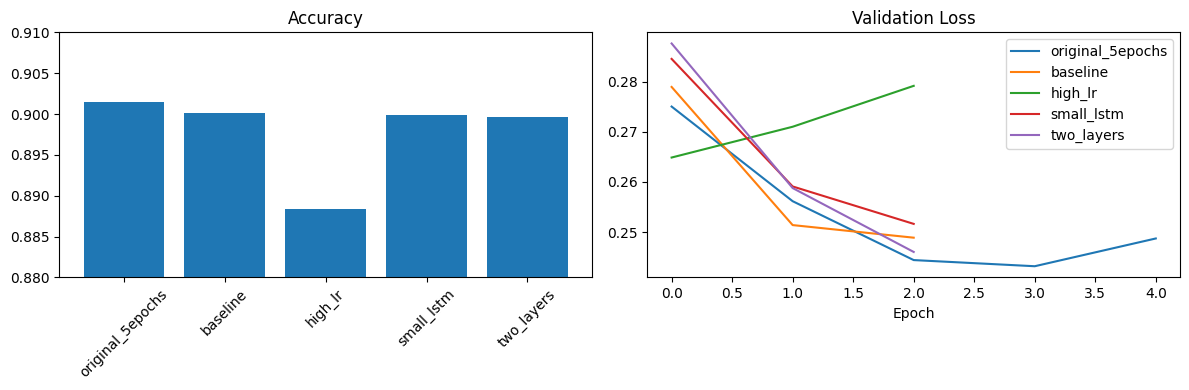

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

names = [r['config']['name'] for r in results]
accuracies = [r['accuracy'] for r in results]
axes[0].set_ylim([0.88, 0.91])
axes[0].bar(names, accuracies)
axes[0].set_title('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

for r in results:
    axes[1].plot(r['history'].history['val_loss'], label=r['config']['name'])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()

In [35]:
best_model = max(results, key=lambda x: x['f1'])
print(f"\n{best_model['config']['name']}")
print(f"F1-Score: {best_model['f1']:.4f}")
print(f"Accuracy: {best_model['accuracy']:.4f}")
print(f"Config: "
      f"LR={best_model['config']['lr']}, "
      f"Epochs={best_model['config']['epochs']}, "
      f"LSTM Units={best_model['config']['lstm_units']}, "
      f"Layers={best_model['config'].get('layers', 1)}")


baseline
F1-Score: 0.9328
Accuracy: 0.9001
Config: LR=0.001, Epochs=3, LSTM Units=128, Layers=1


#### Conclusions
Based on the results, increasing the learning rate from 0.001 to 0.01 causes a significant drop in performance (accuracy drops from 90% to 88.8%)- overly aggressive learning disrupts the convergence process. Adding an additional LSTM layer does not bring improvement. The two-layer model achieves nearly identical F1-score as the baseline model- a single LSTM layer is enough for effective feature extraction from these texts. Similarly, reducing LSTM units from 128 to 64 causes a drop of only 0.15% in F1-score- the smaller network efficiently captures essential patterns without needing larger capacity. The difference between 3 and 5 epochs is minimal (F1-score 93.28% vs. 93.20%)- the model converges quickly and that additional training does not bring big improvement.